# Linear Learner Model

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd 

import boto3
import sagemaker
from sagemaker import get_execution_role

%matplotlib inline

In [2]:
# sagemaker session, role
sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()

# S3 bucket name
bucket = sagemaker_session.default_bucket()

In [3]:
data_dir = 'data'

In [4]:
train_data = pd.read_csv(os.path.join(data_dir, 'train.csv'), header=None).values
validation_data = pd.read_csv(os.path.join(data_dir, 'validation.csv'), header=None).values

In [5]:
X_train = train_data[:,1:]
y_train = train_data[:,0]

X_validation = validation_data[:,1:]
y_validation = validation_data[:,0]

In [6]:
# import LinearLearner
from sagemaker import LinearLearner

# specify an output path
prefix = 'vehicles'
output_path = 's3://{}/{}'.format(bucket, prefix)

# instantiate LinearLearner
linear = LinearLearner(role=role,
                       train_instance_count=1, 
                       train_instance_type='ml.c4.xlarge',
                       predictor_type='regressor',
                       output_path=output_path,
                       sagemaker_session=sagemaker_session,
                       epochs=150,
                       learning_rate=0.03)

In [7]:
X_train_np = X_train.astype('float32')
y_train_np = y_train.astype('float32')

formatted_train_data = linear.record_set(X_train_np, labels=y_train_np)

X_validation_np = X_validation.astype('float32')
y_validation_np = y_validation.astype('float32')

formatted_validation_data = linear.record_set(X_validation_np, labels=y_validation_np, channel='validation')

In [8]:
linear.fit([formatted_train_data,formatted_validation_data])

2020-03-22 05:48:37 Starting - Starting the training job...
2020-03-22 05:48:38 Starting - Launching requested ML instances......
2020-03-22 05:49:39 Starting - Preparing the instances for training......
2020-03-22 05:51:04 Downloading - Downloading input data
2020-03-22 05:51:04 Training - Downloading the training image...
2020-03-22 05:51:23 Training - Training image download completed. Training in progress.Docker entrypoint called with argument(s): train
Running default environment configuration script
[03/22/2020 05:51:26 INFO 140283786311488] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'loss_insensitivity': u'0.01', u'epochs': u'15', u'feature_dim': u'auto', u'init_bias': u'0.0', u'lr_scheduler_factor': u'auto', u'num_calibration_samples': u'10000000', u'accuracy_top_k': u'3', u'_num_kv_servers': u'auto', u'use_bias': u'true', u'num_point_for_scaler': u'10000', u'_log_level': u'info', u'quantile': u'0.5', u'b

In [9]:
linear_predictor = linear.deploy(initial_instance_count=1, instance_type='ml.t2.medium')

-------------!

In [10]:
def chunks(lst, n):
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

def predict(predictor, features, batch_size=100):    
    prediction_batches = [predictor.predict(batch) for batch in chunks(features, batch_size)]
    
    predictions = np.concatenate([np.array([x.label['score'].float32_tensor.values[0] for x in batch])
                                  for batch in prediction_batches])
    
    return predictions

In [11]:
X_test = pd.read_csv(os.path.join(data_dir, 'test.csv'), header=None).values
y_test = pd.read_csv(os.path.join(data_dir, 'test_y.csv'), header=None).values

X_test_np = X_test.astype('float32')
y_test_np = y_test.astype('float32')

In [12]:
predictions = predict(linear_predictor, X_test_np)

predictions

array([29816.41210938, 14533.08984375, 13682.81640625, ...,
       23381.5234375 , 41801.953125  , 26778.99609375])

In [13]:
linear_predictor.delete_endpoint()

In [14]:
labels = np.squeeze(y_test_np)

Text(0.5, 1.0, 'True Price vs Predicted Price')

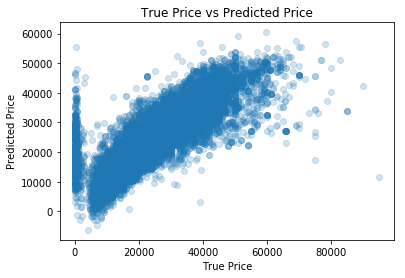

In [15]:
plt.scatter(labels, predictions, alpha=1/5)
plt.xlabel("True Price")
plt.ylabel("Predicted Price")
plt.title("True Price vs Predicted Price")

In [16]:
from sklearn.metrics import r2_score

score = r2_score(labels, predictions)

print('R-squared score: {}'.format(score))

R-squared score: 0.6817723053921639


In [18]:
distances = np.abs(labels - predictions)

max_distance = np.max(distances)
min_distance = np.min(distances)
mean_distance = np.mean(distances)

print('Min distance: {}'.format(min_distance))
print('Max distance: {}'.format(max_distance))
print('Mean distance: {}'.format(mean_distance))

Min distance: 0.140625
Max distance: 83490.4296875
Mean distance: 4087.6143771372467
